In [22]:
import json
import os
import numpy as np
import itertools

from transformers import PreTrainedTokenizerFast, AutoTokenizer, AutoConfig
from transformers import XLMRobertaTokenizerFast
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
from notebook_utils import *

# Load the results for XNLI (cross-lingual transfer)

In [14]:
pwd

'/mnt/sshfs/MFF_UFAL/my-luster/entangled-in-scripts/entangled_in_scripts/src/notebooks'

In [18]:
result_dir = "../../../models"

languages = ('ar', 'tr', 'zh', 'el', 'es', 'en')

tokenizer_types = ('bpe-tokenization', 'merged-tokenization', 'multilingual-tokenization', 'nooverlap-tokenization')
vocab_sizes = (120000, 120000, 120000, 20000)

In [21]:
task = 'XNLI'
post_training = 'PROBE'
metric = 'accuracy'

xnli_results = []

for lang_src in languages:
    for lang_tgt in languages:
        for tok_type, vocab_size in zip(tokenizer_types, vocab_sizes):
            probe = "_probe" if post_training == "PROBE" else ""
            result_file = f"{result_dir}/{task}_{post_training}/{tok_type}/alpha-0.25_alpha-train-0.25_N-{vocab_size}{probe}_8888/{lang_src}/{metric}_evaluation/{lang_tgt}/{metric}_all.txt"
            
            if not os.path.exists(result_file):
                print("not found! skipping", result_file)
                continue
            with open(result_file, 'r') as in_file:
                res = json.load(in_file)[f'eval_{metric}']

            xnli_results.append(
                {
                    'lang_src': lang_src,
                    'lang_tgt': lang_tgt,
                    'tokenizer_type': tok_type,
                    'vocab_size': vocab_size,
                    'accuracy': res
                }
            )

not found! skipping ../../../models/XNLI_PROBE/multilingual-tokenization/alpha-0.25_alpha-train-0.25_N-120000_probe_8888/es/accuracy_evaluation/tr/accuracy_all.txt


Text(0.5, 1.0, 'mean XNLI PROBE accuracy for all languages')

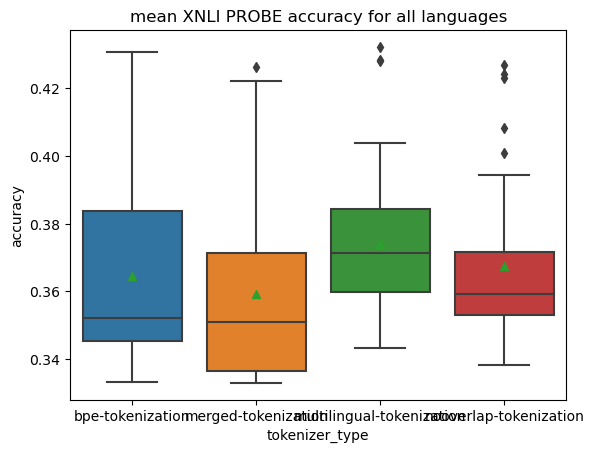

In [55]:
df = pd.DataFrame(xnli_results)

# df_overall = df.groupby(['tokenizer_type']).mean().reset_index()
# plot boxplot with mean accuracy for each tokenizer type

sns.boxplot(x='tokenizer_type', y='accuracy', data=df, showmeans=True)
plt.title(f"mean XNLI {post_training} {metric} for all languages")

/home/jirka/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/jirka/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/jirka/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/jirka/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/jirka/.local/lib/python3.10/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is

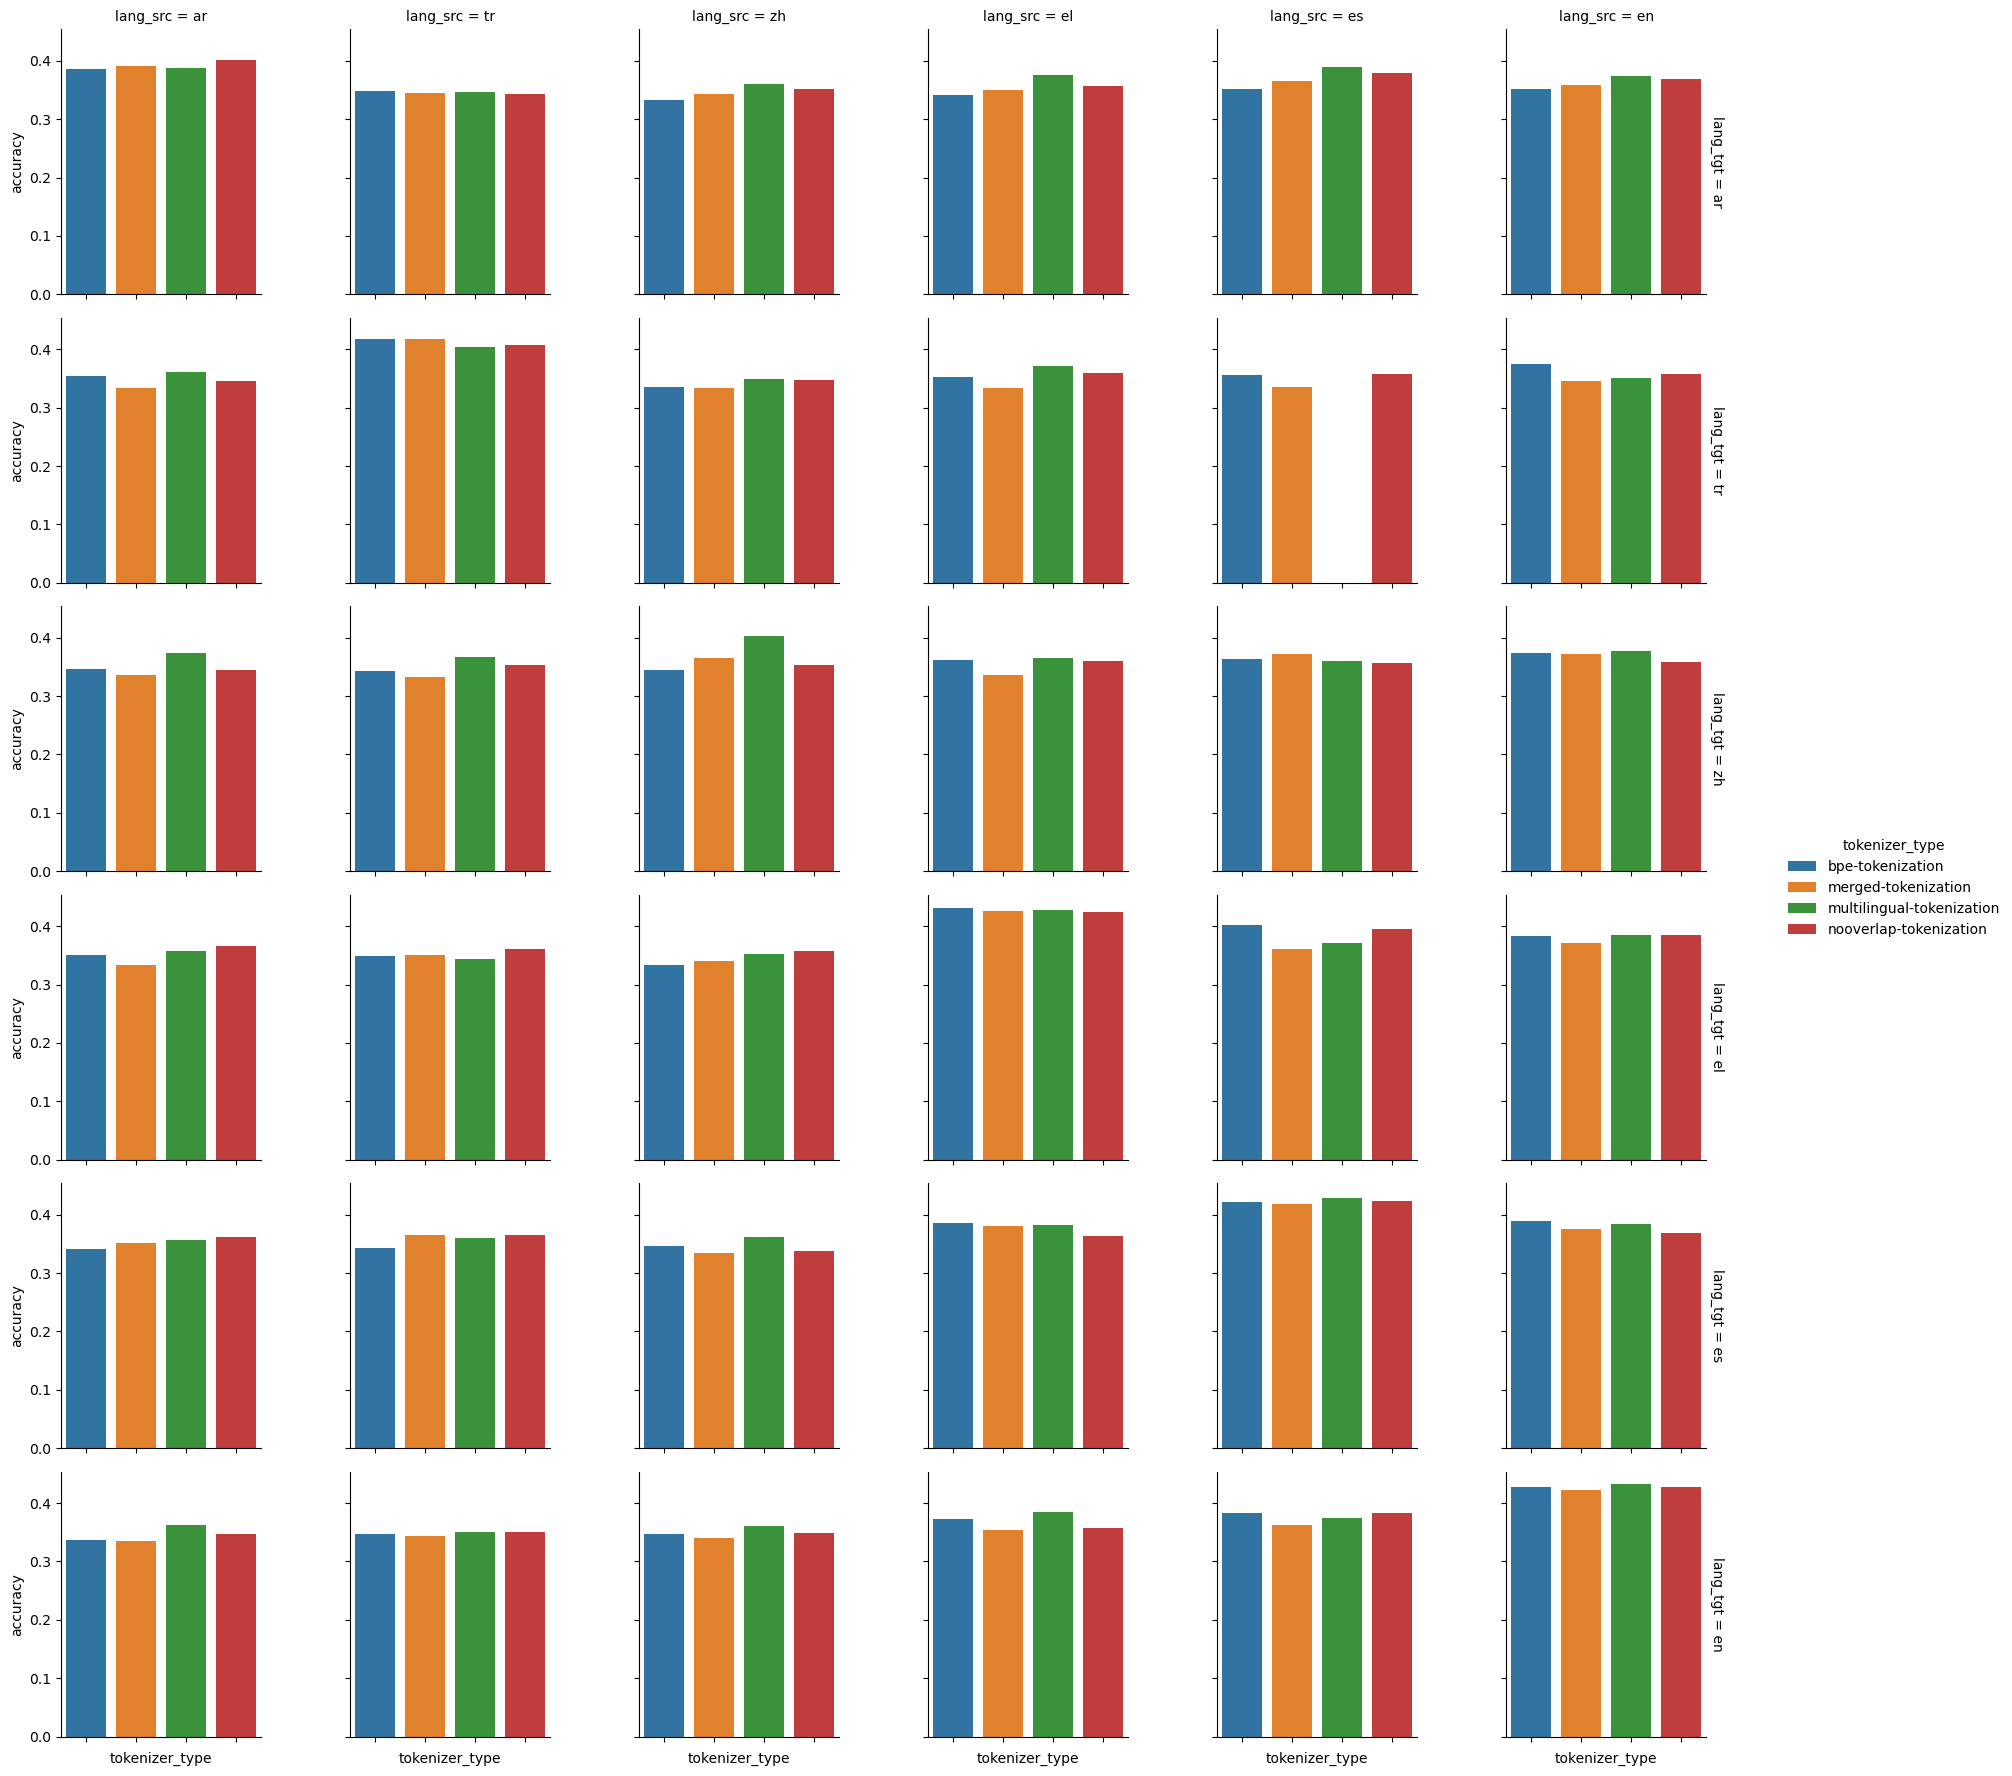

In [61]:
# plot barplot FacetGrid for lang_src and lang_tgt with tokenizer_type as hue and accuracy as value
# 45 deg rotation for xticks
g = sns.FacetGrid(df, col="lang_src", row="lang_tgt", hue="tokenizer_type", margin_titles=True)
g.map(sns.barplot, "tokenizer_type", "accuracy", order=tokenizer_types)
# g.set_xticklabels(rotation=45)
# for axes in g.axes.flat:
#     _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45)
# show legend
g.add_legend()

/tmp/ipykernel_280705/3275068885.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_multilingual = df_multilingual.pivot("lang_src", "lang_tgt", "accuracy")


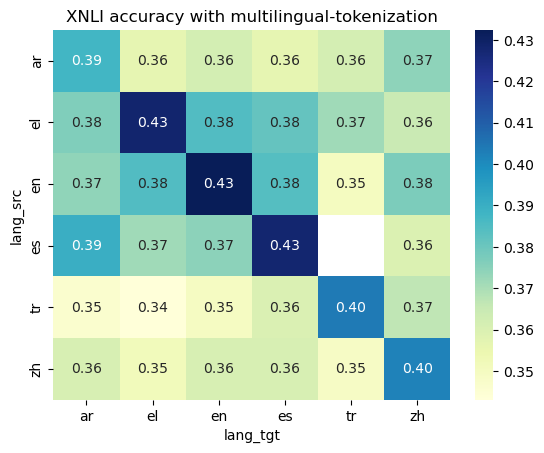

/tmp/ipykernel_280705/3275068885.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_delta = df_delta.pivot("lang_src", "lang_tgt", "accuracy")


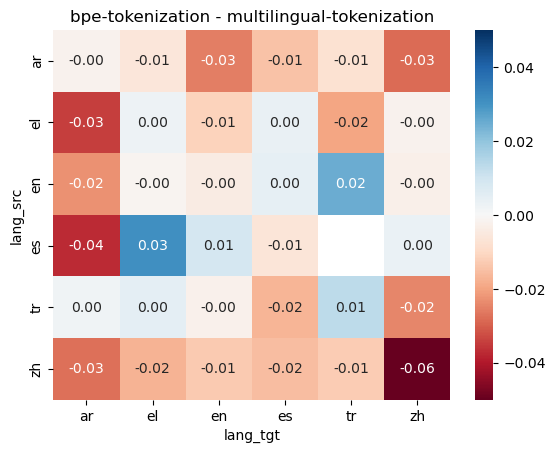

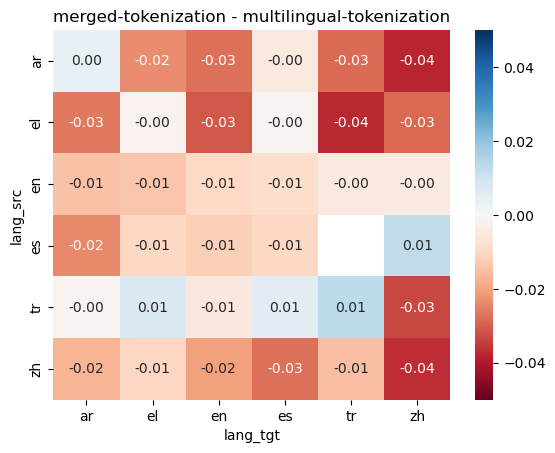

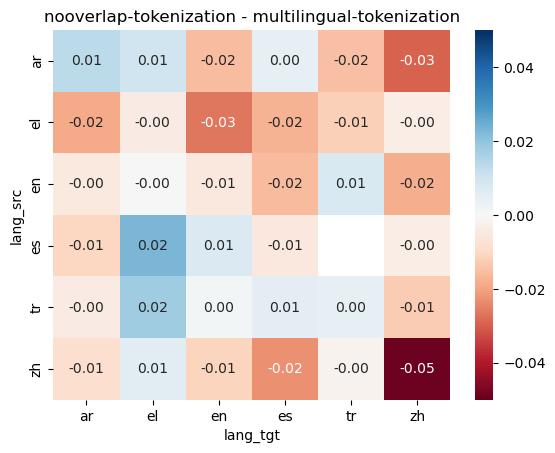

In [60]:
# plot heatmap for lang_src and lang_tgt with accuracy as value for tokenizer_type == 'multilingual-tokenization'
df_multilingual = df[df['tokenizer_type'] == 'multilingual-tokenization']
df_multilingual = df_multilingual.pivot("lang_src", "lang_tgt", "accuracy")
sns.heatmap(df_multilingual, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title(f"XNLI accuracy with multilingual-tokenization")
plt.show()
# plot heatmaps for the rest of the tokenizer_types as a delta to 'multilingual-tokenization'
for tok_type in tokenizer_types:
    if tok_type == 'multilingual-tokenization':
        continue
    df_delta = df[df['tokenizer_type'] == tok_type]
    df_delta = df_delta.pivot("lang_src", "lang_tgt", "accuracy")
    df_delta = df_delta - df_multilingual
    # choose a diverging colormap
    # set the scale to be between -1 and 1
    sns.heatmap(df_delta, annot=True, fmt=".2f", cmap="RdBu", vmin=-0.05, vmax=0.05)
    plt.title(f"{tok_type} - multilingual-tokenization")
    plt.show()